<a href="https://colab.research.google.com/github/samyogbhatta/group6_MLPC-grpAssignment/blob/main/grp6GA(MLPC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pygad
!pip install torch

Imports and Seed Setting

In [ ]:
import numpy as np
import pandas as pd
import pygad
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


Dataset Generation

In [ ]:
def generate_smart_grid_dataset(nodes=30, sources=3, hours=24):
    data = {
        'Hour': np.repeat(range(hours), nodes),
        'Node': np.tile(range(nodes), hours),
        'Demand_MW': np.random.uniform(50, 200, nodes * hours),
        'Solar_Capacity_MW': np.random.uniform(0, 100, nodes * hours),
        'Wind_Capacity_MW': np.random.uniform(0, 150, nodes * hours),
        'Hydro_Capacity_MW': np.random.uniform(0, 120, nodes * hours),
        'Line_Loss_Factor': np.random.uniform(0.05, 0.15, nodes * hours),
        'Cost_Solar': np.random.uniform(0.08, 0.12, nodes * hours),
        'Cost_Wind': np.random.uniform(0.06, 0.10, nodes * hours),
        'Cost_Hydro': np.random.uniform(0.04, 0.08, nodes * hours),
    }
    df = pd.DataFrame(data)
    return df

dataset = generate_smart_grid_dataset()
dataset.head()


,Hour,Node,Demand_MW,Solar_Capacity_MW,Wind_Capacity_MW,Hydro_Capacity_MW,Line_Loss_Factor,Cost_Solar,Cost_Wind,Cost_Hydro
0,0,0,106.181018,93.834046,145.486807,78.137710,0.083156,0.085649,0.083226,0.070488
1,0,1,192.607146,18.123307,14.085107,74.511428,0.135503,0.102835,0.097437,0.063669
2,0,2,159.799091,6.649627,100.890318,42.284994,0.070708,0.087411,0.086890,0.047681
3,0,3,139.798773,74.112065,66.562533,100.973706,0.057116,0.091146,0.079251,0.066667
4,0,4,73.402796,57.447311,130.221338,56.554460,0.056901,0.088748,0.092387,0.064935


Smart Grid Optimizer Class

In [ ]:
class SmartGridOptimizer:
    def __init__(self, dataset, nodes=30, sources=3, hours=24):
        self.dataset = dataset
        self.nodes = nodes
        self.sources = sources
        self.hours = hours
        self.max_capacity = {
            'Solar': dataset['Solar_Capacity_MW'].values.reshape(hours, nodes),
            'Wind': dataset['Wind_Capacity_MW'].values.reshape(hours, nodes),
            'Hydro': dataset['Hydro_Capacity_MW'].values.reshape(hours, nodes)
        }
        self.demand = dataset['Demand_MW'].values.reshape(hours, nodes)
        self.line_loss = dataset['Line_Loss_Factor'].values.reshape(hours, nodes)
        self.costs = {
            'Solar': dataset['Cost_Solar'].values.reshape(hours, nodes),
            'Wind': dataset['Cost_Wind'].values.reshape(hours, nodes),
            'Hydro': dataset['Cost_Hydro'].values.reshape(hours, nodes)
        }

    def fitness_function(self, ga_instance, solution, solution_idx):
        solution = solution.reshape(self.hours, self.nodes, self.sources)
        solution_tensor = torch.tensor(solution, dtype=torch.float32)

        cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            cost += torch.sum(solution_tensor[:, :, s] * torch.tensor(self.costs[source], dtype=torch.float32) * 1000)

        line_loss_tensor = torch.tensor(self.line_loss, dtype=torch.float32).unsqueeze(2).expand(-1, -1, self.sources)
        loss = torch.sum(solution_tensor * line_loss_tensor)

        total_supply = torch.sum(solution_tensor, dim=2)
        demand_penalty = torch.sum(torch.abs(total_supply - torch.tensor(self.demand, dtype=torch.float32)))

        penalty = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            excess = torch.relu(solution_tensor[:, :, s] - torch.tensor(self.max_capacity[source], dtype=torch.float32))
            penalty += torch.sum(excess) * 1000

        fitness = -(cost + 0.5 * loss + 0.1 * demand_penalty + penalty)
        return fitness.item()

    def chromosome_encoding(self):
        gene_space = [{'low': 0, 'high': 200} for _ in range(self.hours * self.nodes * self.sources)]
        return gene_space

    def greedy_baseline(self):
        allocation = np.zeros((self.hours, self.nodes, self.sources))
        demand_remaining = self.demand.copy()
        source_order = ['Hydro', 'Wind', 'Solar']
        for s, source in enumerate(source_order):
            capacity = self.max_capacity[source]
            for h in range(self.hours):
                for n in range(self.nodes):
                    allocated = min(demand_remaining[h, n], capacity[h, n])
                    allocation[h, n, s] = allocated
                    demand_remaining[h, n] -= allocated

        total_cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            total_cost += np.sum(allocation[:, :, s] * self.costs[source] * 1000)
        return total_cost, allocation


GA Run Function

In [ ]:
def run_ga(optimizer, parallel=True):
    ga_instance = pygad.GA(
        num_generations=100,
        num_parents_mating=20,
        fitness_func=optimizer.fitness_function,
        sol_per_pop=50,
        num_genes=optimizer.hours * optimizer.nodes * optimizer.sources,
        gene_space=optimizer.chromosome_encoding(),
        mutation_percent_genes=10,
        parallel_processing=['process', os.cpu_count()] if parallel else None
    )
    start = time.time()
    ga_instance.run()
    end = time.time()
    best_solution = ga_instance.best_solution()[0].reshape(optimizer.hours, optimizer.nodes, optimizer.sources)
    best_fitness = ga_instance.best_solution()[1]
    exec_time = end - start
    return ga_instance, exec_time, best_fitness, best_solution


Visualization Function

In [ ]:
def visualize_results(parallel_ga, serial_ga, greedy_cost, parallel_time, serial_time, parallel_fitness, serial_fitness, dataset):
    # Summary Table
    summary = pd.DataFrame({
        'Method': ['Greedy', 'GA Parallel', 'GA Serial'],
        'Execution Time (s)': [0, parallel_time, serial_time],
        'Total Cost / -Fitness': [greedy_cost, -parallel_fitness, -serial_fitness]
    })
    print("\nSummary Comparison Table:")
    print(summary)

    # Convergence Curve
    plt.figure(figsize=(10, 5))
    plt.plot(parallel_ga.best_solutions_fitness, label='Parallel GA')
    plt.plot(serial_ga.best_solutions_fitness, label='Serial GA')
    plt.axhline(y=-greedy_cost, color='gray', linestyle='--', label='Greedy Baseline')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Convergence Curve (Parallel GA vs Serial GA)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Cost Comparison Bar Chart
    plt.figure(figsize=(6, 4))
    plt.bar(['GA (Parallel)', 'GA (Serial)', 'Greedy'],
            [-parallel_fitness, -serial_fitness, greedy_cost],
            color=['blue', 'red', 'gray'])
    plt.title("Cost Comparison")
    plt.ylabel("Cost ($)")
    plt.show()

    # Correlation Heatmap Between Key Variables
    key_variables = dataset.copy()
    key_variables['AvgCost'] = (dataset['Cost_Solar'] + dataset['Cost_Wind'] + dataset['Cost_Hydro']) / 3
    key_variables['MinCost'] = dataset[['Cost_Solar', 'Cost_Wind', 'Cost_Hydro']].min(axis=1)
    key_variables['MaxCost'] = dataset[['Cost_Solar', 'Cost_Wind', 'Cost_Hydro']].max(axis=1)
    key_variables['AvgLoss'] = dataset['Line_Loss_Factor']
    key_variables['MinLoss'] = dataset['Line_Loss_Factor']
    key_variables['MaxLoss'] = dataset['Line_Loss_Factor']
    key_variables['AvgCapacity'] = (dataset['Solar_Capacity_MW'] + dataset['Wind_Capacity_MW'] + dataset['Hydro_Capacity_MW']) / 3
    key_variables['TotalCapacity'] = dataset[['Solar_Capacity_MW', 'Wind_Capacity_MW', 'Hydro_Capacity_MW']].sum(axis=1)

    corr_data = key_variables[['Demand_MW', 'AvgCost', 'MinCost', 'MaxCost',
                               'AvgLoss', 'MinLoss', 'MaxLoss', 'AvgCapacity', 'TotalCapacity']]
    corr_data.columns = ['Demand', 'AvgCost', 'MinCost', 'MaxCost',
                         'AvgLoss', 'MinLoss', 'MaxLoss', 'AvgCapacity', 'TotalCapacity']

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap Between Key Variables", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



Summary Comparison Table:
        Method  Execution Time (s)  Total Cost / -Fitness
0       Greedy            0.000000           7.167173e+06
1  GA Parallel          140.729677           1.075425e+08
2    GA Serial           13.986196           1.051694e+08


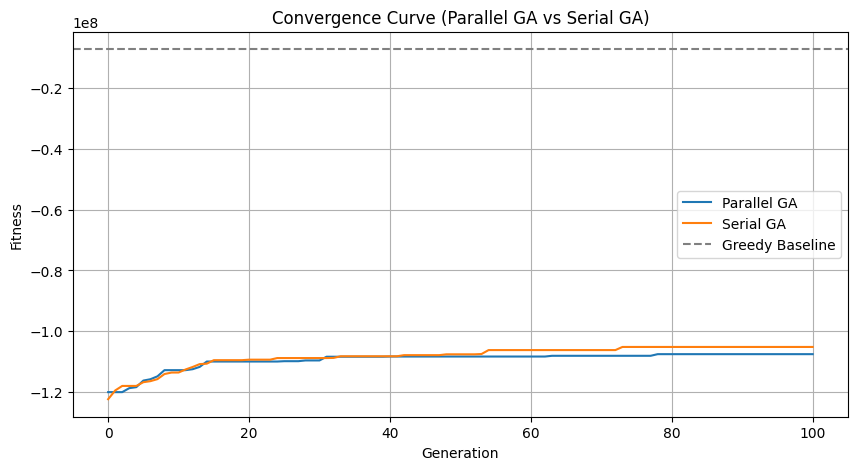

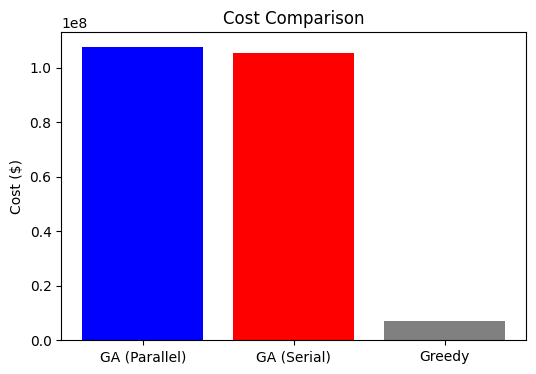

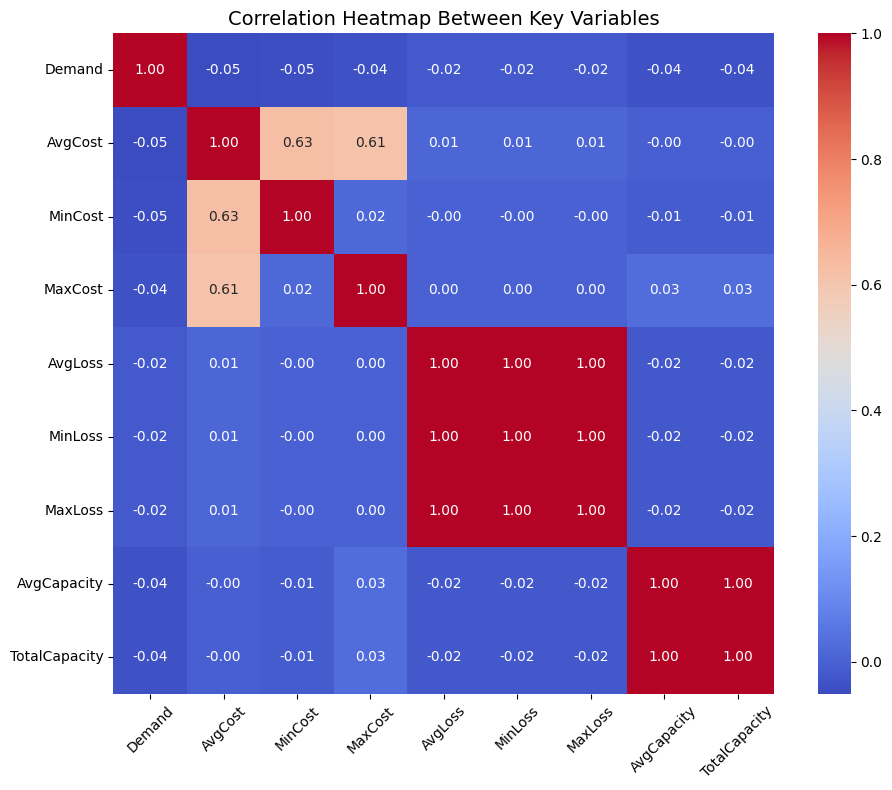

In [ ]:
optimizer = SmartGridOptimizer(dataset)

# Greedy baseline
greedy_cost, greedy_sol = optimizer.greedy_baseline()

# Run GA Parallel & Serial
parallel_ga, parallel_time, parallel_fitness, parallel_sol = run_ga(optimizer, parallel=True)
serial_ga, serial_time, serial_fitness, serial_sol = run_ga(optimizer, parallel=False)

# Visualize results
visualize_results(parallel_ga, serial_ga, greedy_cost, parallel_time, serial_time, parallel_fitness, serial_fitness, dataset)



Summary Comparison Table:
        Method  Execution Time (s)  Total Cost / -Fitness
0       Greedy            0.001851           7.167173e+06
1  GA Parallel          146.917295           1.065677e+08
2    GA Serial           13.616772           1.038382e+08


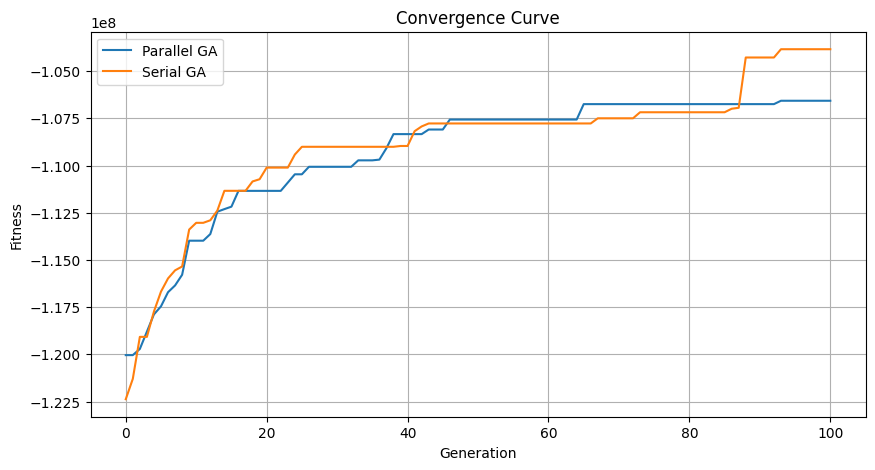

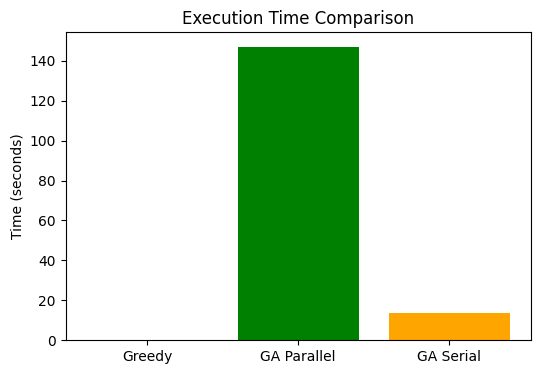

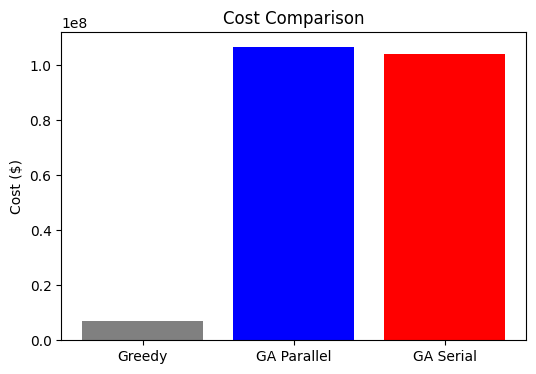

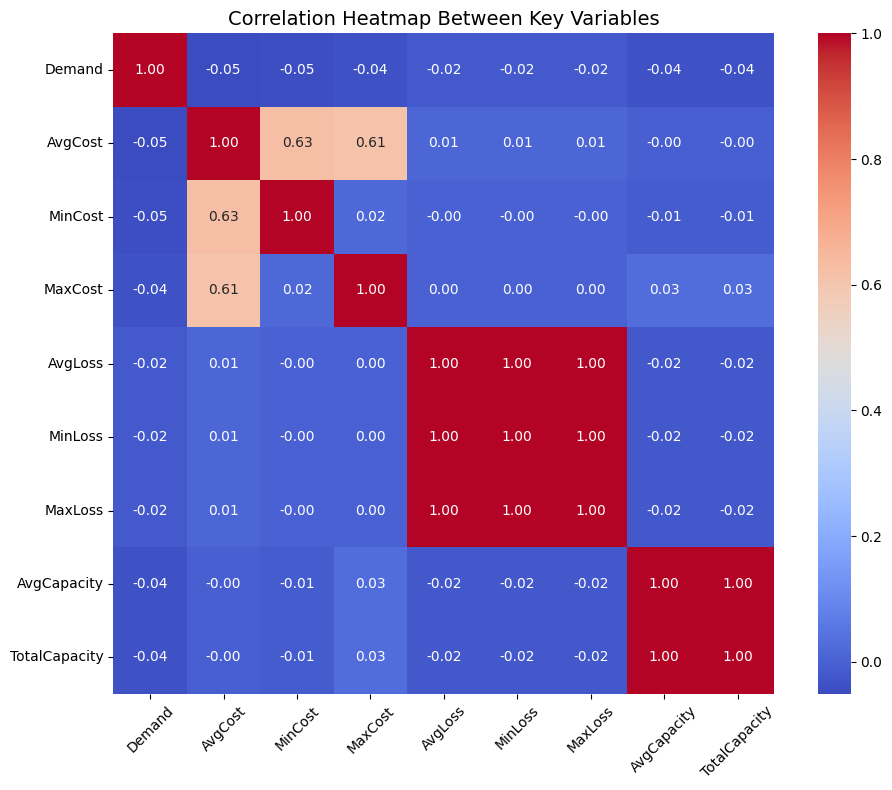

In [ ]:
import numpy as np
import pandas as pd
import pygad
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Generate Realistic Dataset
def generate_smart_grid_dataset(nodes=30, sources=3, hours=24):
    data = {
        'Hour': np.repeat(range(hours), nodes),
        'Node': np.tile(range(nodes), hours),
        'Demand_MW': np.random.uniform(50, 200, nodes * hours),
        'Solar_Capacity_MW': np.random.uniform(0, 100, nodes * hours),
        'Wind_Capacity_MW': np.random.uniform(0, 150, nodes * hours),
        'Hydro_Capacity_MW': np.random.uniform(0, 120, nodes * hours),
        'Line_Loss_Factor': np.random.uniform(0.05, 0.15, nodes * hours),
        'Cost_Solar': np.random.uniform(0.08, 0.12, nodes * hours),
        'Cost_Wind': np.random.uniform(0.06, 0.10, nodes * hours),
        'Cost_Hydro': np.random.uniform(0.04, 0.08, nodes * hours),
    }
    df = pd.DataFrame(data)
    return df

dataset = generate_smart_grid_dataset()

# 2. Problem Formulation
class SmartGridOptimizer:
    def __init__(self, dataset, nodes=30, sources=3, hours=24):
        self.dataset = dataset
        self.nodes = nodes
        self.sources = sources
        self.hours = hours
        self.max_capacity = {
            'Solar': dataset['Solar_Capacity_MW'].values.reshape(hours, nodes),
            'Wind': dataset['Wind_Capacity_MW'].values.reshape(hours, nodes),
            'Hydro': dataset['Hydro_Capacity_MW'].values.reshape(hours, nodes)
        }
        self.demand = dataset['Demand_MW'].values.reshape(hours, nodes)
        self.line_loss = dataset['Line_Loss_Factor'].values.reshape(hours, nodes)
        self.costs = {
            'Solar': dataset['Cost_Solar'].values.reshape(hours, nodes),
            'Wind': dataset['Cost_Wind'].values.reshape(hours, nodes),
            'Hydro': dataset['Cost_Hydro'].values.reshape(hours, nodes)
        }

    def fitness_function(self, ga_instance, solution, solution_idx):
        solution = solution.reshape(self.hours, self.nodes, self.sources)
        solution_tensor = torch.tensor(solution, dtype=torch.float32)

        cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            cost += torch.sum(solution_tensor[:, :, s] * torch.tensor(self.costs[source], dtype=torch.float32) * 1000)

        line_loss_tensor = torch.tensor(self.line_loss, dtype=torch.float32).unsqueeze(2).expand(-1, -1, self.sources)
        loss = torch.sum(solution_tensor * line_loss_tensor)

        total_supply = torch.sum(solution_tensor, dim=2)
        demand_penalty = torch.sum(torch.abs(total_supply - torch.tensor(self.demand, dtype=torch.float32)))

        penalty = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            excess = torch.relu(solution_tensor[:, :, s] - torch.tensor(self.max_capacity[source], dtype=torch.float32))
            penalty += torch.sum(excess) * 1000

        fitness = -(cost + 0.5 * loss + 0.1 * demand_penalty + penalty)
        return fitness.item()

    def chromosome_encoding(self):
        gene_space = [{'low': 0, 'high': 200} for _ in range(self.hours * self.nodes * self.sources)]
        return gene_space

    def greedy_baseline(self):
        allocation = np.zeros((self.hours, self.nodes, self.sources))
        demand_remaining = self.demand.copy()
        source_order = ['Hydro', 'Wind', 'Solar']
        for s, source in enumerate(source_order):
            capacity = self.max_capacity[source]
            for h in range(self.hours):
                for n in range(self.nodes):
                    allocated = min(demand_remaining[h, n], capacity[h, n])
                    allocation[h, n, s] = allocated
                    demand_remaining[h, n] -= allocated

        total_cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            total_cost += np.sum(allocation[:, :, s] * self.costs[source] * 1000)
        return total_cost, allocation

# 3. GA Execution
def run_ga(optimizer, parallel=True):
    ga_instance = pygad.GA(
        num_generations=100,
        num_parents_mating=20,
        fitness_func=optimizer.fitness_function,
        sol_per_pop=50,
        num_genes=optimizer.hours * optimizer.nodes * optimizer.sources,
        gene_space=optimizer.chromosome_encoding(),
        mutation_percent_genes=10,
        parallel_processing=['process', os.cpu_count()] if parallel else None
    )
    start = time.time()
    ga_instance.run()
    end = time.time()
    best_solution = ga_instance.best_solution()[0].reshape(optimizer.hours, optimizer.nodes, optimizer.sources)
    best_fitness = ga_instance.best_solution()[1]
    return ga_instance, end - start, best_fitness, best_solution

# Correlation Heatmap of Key Dataset Variables
def visualize_correlation_heatmap(dataset):
    key_variables = dataset.copy()
    key_variables['AvgCost'] = (dataset['Cost_Solar'] + dataset['Cost_Wind'] + dataset['Cost_Hydro']) / 3
    key_variables['MinCost'] = dataset[['Cost_Solar', 'Cost_Wind', 'Cost_Hydro']].min(axis=1)
    key_variables['MaxCost'] = dataset[['Cost_Solar', 'Cost_Wind', 'Cost_Hydro']].max(axis=1)
    key_variables['AvgLoss'] = dataset['Line_Loss_Factor']
    key_variables['MinLoss'] = dataset['Line_Loss_Factor']
    key_variables['MaxLoss'] = dataset['Line_Loss_Factor']
    key_variables['AvgCapacity'] = (dataset['Solar_Capacity_MW'] + dataset['Wind_Capacity_MW'] + dataset['Hydro_Capacity_MW']) / 3
    key_variables['TotalCapacity'] = dataset[['Solar_Capacity_MW', 'Wind_Capacity_MW', 'Hydro_Capacity_MW']].sum(axis=1)

    corr_data = key_variables[['Demand_MW', 'AvgCost', 'MinCost', 'MaxCost',
                               'AvgLoss', 'MinLoss', 'MaxLoss', 'AvgCapacity', 'TotalCapacity']]
    corr_data.columns = ['Demand', 'AvgCost', 'MinCost', 'MaxCost',
                         'AvgLoss', 'MinLoss', 'MaxLoss', 'AvgCapacity', 'TotalCapacity']

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap Between Key Variables", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 4. Main Execution
def main():
    optimizer = SmartGridOptimizer(dataset)

    # Greedy baseline
    start_greedy = time.time()
    greedy_cost, greedy_sol = optimizer.greedy_baseline()
    end_greedy = time.time()
    greedy_time = end_greedy - start_greedy

    # Run GA Parallel & Serial
    parallel_ga, parallel_time, parallel_fitness, parallel_sol = run_ga(optimizer, parallel=True)
    serial_ga, serial_time, serial_fitness, serial_sol = run_ga(optimizer, parallel=False)

    # Summary Table
    summary = pd.DataFrame({
        'Method': ['Greedy', 'GA Parallel', 'GA Serial'],
        'Execution Time (s)': [greedy_time, parallel_time, serial_time],
        'Total Cost / -Fitness': [greedy_cost, -parallel_fitness, -serial_fitness]
    })

    print("\nSummary Comparison Table:")
    print(summary)

    # Convergence curve
    plt.figure(figsize=(10, 5))
    plt.plot(parallel_ga.best_solutions_fitness, label='Parallel GA')
    plt.plot(serial_ga.best_solutions_fitness, label='Serial GA')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Convergence Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Execution Time Comparison (include greedy time)
    plt.figure(figsize=(6, 4))
    plt.bar(['Greedy', 'GA Parallel', 'GA Serial'], [greedy_time, parallel_time, serial_time],
            color=['gray', 'green', 'orange'])
    plt.title("Execution Time Comparison")
    plt.ylabel("Time (seconds)")
    plt.show()

    # Cost Comparison
    plt.figure(figsize=(6, 4))
    plt.bar(['Greedy', 'GA Parallel', 'GA Serial'], [greedy_cost, -parallel_fitness, -serial_fitness],
            color=['gray', 'blue', 'red'])
    plt.title("Cost Comparison")
    plt.ylabel("Cost ($)")
    plt.show()

    # Correlation Heatmap of Dataset Variables
    visualize_correlation_heatmap(dataset)

if __name__ == "__main__":
    main()


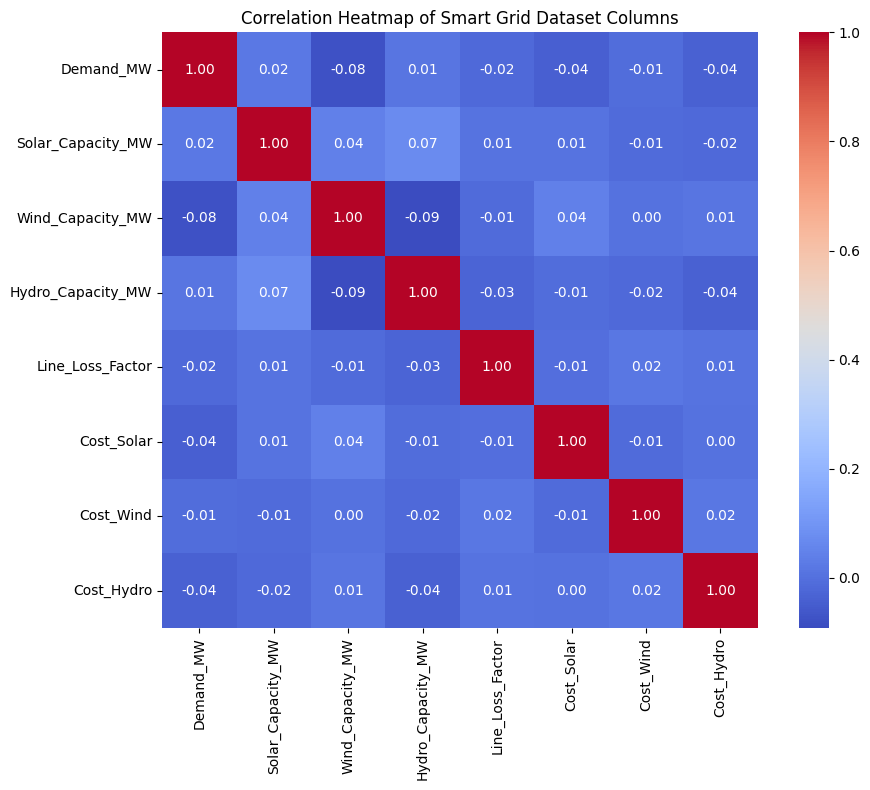


Summary Comparison Table:
        Method  Execution Time (s)  Total Cost / -Fitness
0       Greedy            0.002120           7.167173e+06
1  GA Parallel          171.744462           1.063495e+08
2    GA Serial           15.226884           1.060548e+08


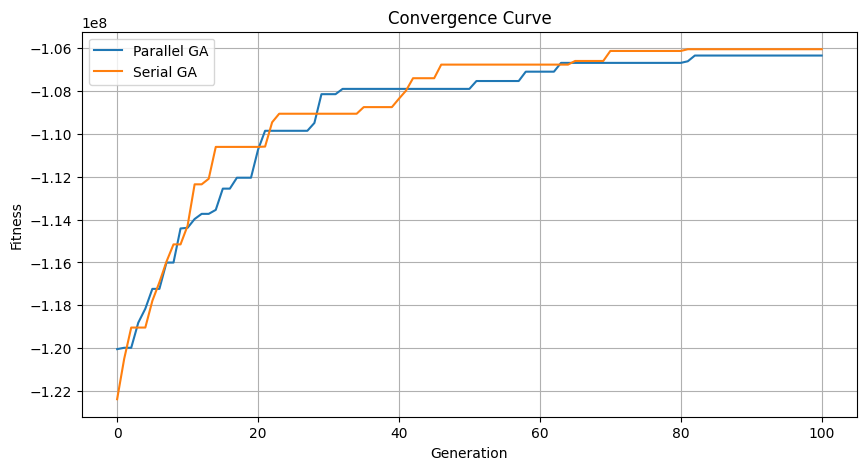

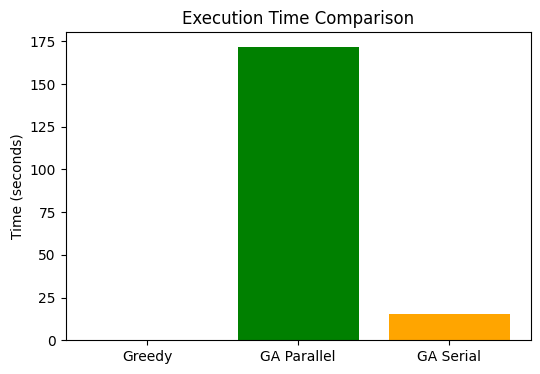

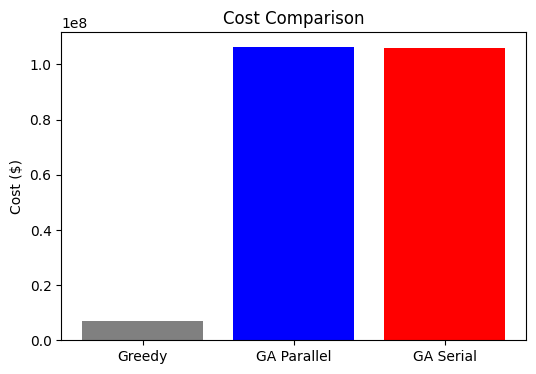

In [ ]:
import numpy as np
import pandas as pd
import pygad
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Generate Realistic Dataset
def generate_smart_grid_dataset(nodes=30, sources=3, hours=24):
    data = {
        'Hour': np.repeat(range(hours), nodes),
        'Node': np.tile(range(nodes), hours),
        'Demand_MW': np.random.uniform(50, 200, nodes * hours),
        'Solar_Capacity_MW': np.random.uniform(0, 100, nodes * hours),
        'Wind_Capacity_MW': np.random.uniform(0, 150, nodes * hours),
        'Hydro_Capacity_MW': np.random.uniform(0, 120, nodes * hours),
        'Line_Loss_Factor': np.random.uniform(0.05, 0.15, nodes * hours),
        'Cost_Solar': np.random.uniform(0.08, 0.12, nodes * hours),
        'Cost_Wind': np.random.uniform(0.06, 0.10, nodes * hours),
        'Cost_Hydro': np.random.uniform(0.04, 0.08, nodes * hours),
    }
    df = pd.DataFrame(data)
    return df

dataset = generate_smart_grid_dataset()

# 2. Problem Formulation
class SmartGridOptimizer:
    def __init__(self, dataset, nodes=30, sources=3, hours=24):
        self.dataset = dataset
        self.nodes = nodes
        self.sources = sources
        self.hours = hours
        self.max_capacity = {
            'Solar': dataset['Solar_Capacity_MW'].values.reshape(hours, nodes),
            'Wind': dataset['Wind_Capacity_MW'].values.reshape(hours, nodes),
            'Hydro': dataset['Hydro_Capacity_MW'].values.reshape(hours, nodes)
        }
        self.demand = dataset['Demand_MW'].values.reshape(hours, nodes)
        self.line_loss = dataset['Line_Loss_Factor'].values.reshape(hours, nodes)
        self.costs = {
            'Solar': dataset['Cost_Solar'].values.reshape(hours, nodes),
            'Wind': dataset['Cost_Wind'].values.reshape(hours, nodes),
            'Hydro': dataset['Cost_Hydro'].values.reshape(hours, nodes)
        }

    def fitness_function(self, ga_instance, solution, solution_idx):
        solution = solution.reshape(self.hours, self.nodes, self.sources)
        solution_tensor = torch.tensor(solution, dtype=torch.float32)

        cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            cost += torch.sum(solution_tensor[:, :, s] * torch.tensor(self.costs[source], dtype=torch.float32) * 1000)

        line_loss_tensor = torch.tensor(self.line_loss, dtype=torch.float32).unsqueeze(2).expand(-1, -1, self.sources)
        loss = torch.sum(solution_tensor * line_loss_tensor)

        total_supply = torch.sum(solution_tensor, dim=2)
        demand_penalty = torch.sum(torch.abs(total_supply - torch.tensor(self.demand, dtype=torch.float32)))

        penalty = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            excess = torch.relu(solution_tensor[:, :, s] - torch.tensor(self.max_capacity[source], dtype=torch.float32))
            penalty += torch.sum(excess) * 1000

        fitness = -(cost + 0.5 * loss + 0.1 * demand_penalty + penalty)
        return fitness.item()

    def chromosome_encoding(self):
        gene_space = [{'low': 0, 'high': 200} for _ in range(self.hours * self.nodes * self.sources)]
        return gene_space

    def greedy_baseline(self):
        allocation = np.zeros((self.hours, self.nodes, self.sources))
        demand_remaining = self.demand.copy()
        source_order = ['Hydro', 'Wind', 'Solar']
        for s, source in enumerate(source_order):
            capacity = self.max_capacity[source]
            for h in range(self.hours):
                for n in range(self.nodes):
                    allocated = min(demand_remaining[h, n], capacity[h, n])
                    allocation[h, n, s] = allocated
                    demand_remaining[h, n] -= allocated

        total_cost = 0
        for s, source in enumerate(['Solar', 'Wind', 'Hydro']):
            total_cost += np.sum(allocation[:, :, s] * self.costs[source] * 1000)
        return total_cost, allocation

# 3. GA Execution
def run_ga(optimizer, parallel=True):
    ga_instance = pygad.GA(
        num_generations=100,
        num_parents_mating=20,
        fitness_func=optimizer.fitness_function,
        sol_per_pop=50,
        num_genes=optimizer.hours * optimizer.nodes * optimizer.sources,
        gene_space=optimizer.chromosome_encoding(),
        mutation_percent_genes=10,
        parallel_processing=['process', os.cpu_count()] if parallel else None
    )
    start = time.time()
    ga_instance.run()
    end = time.time()
    best_solution = ga_instance.best_solution()[0].reshape(optimizer.hours, optimizer.nodes, optimizer.sources)
    best_fitness = ga_instance.best_solution()[1]
    return ga_instance, end - start, best_fitness, best_solution




# 4. Main Execution
def main():
    optimizer = SmartGridOptimizer(dataset)

    # Greedy baseline
    start_greedy = time.time()
    greedy_cost, greedy_sol = optimizer.greedy_baseline()
    end_greedy = time.time()
    greedy_time = end_greedy - start_greedy

    # Run GA Parallel & Serial
    parallel_ga, parallel_time, parallel_fitness, parallel_sol = run_ga(optimizer, parallel=True)
    serial_ga, serial_time, serial_fitness, serial_sol = run_ga(optimizer, parallel=False)

    # Summary Table
    summary = pd.DataFrame({
        'Method': ['Greedy', 'GA Parallel', 'GA Serial'],
        'Execution Time (s)': [greedy_time, parallel_time, serial_time],
        'Total Cost / -Fitness': [greedy_cost, -parallel_fitness, -serial_fitness]
    })

    print("\nSummary Comparison Table:")
    print(summary)

    # Select only the numeric columns for correlation
    numeric_data = data.drop(columns=['Hour', 'Node'])  # Exclude non-numeric columns

    # Compute correlation matrix
    corr_matrix = numeric_data.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title("Correlation Heatmap of Smart Grid Dataset Columns")
    plt.tight_layout()
    plt.show()
    plt.close()

    # Convergence curve
    plt.figure(figsize=(10, 5))
    plt.plot(parallel_ga.best_solutions_fitness, label='Parallel GA')
    plt.plot(serial_ga.best_solutions_fitness, label='Serial GA')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Convergence Curve")
    plt.legend()
    plt.grid(True)
    plt.show()



    # Execution Time Comparison (include greedy time)
    plt.figure(figsize=(6, 4))
    plt.bar(['Greedy', 'GA Parallel', 'GA Serial'], [greedy_time, parallel_time, serial_time],
            color=['gray', 'green', 'orange'])
    plt.title("Execution Time Comparison")
    plt.ylabel("Time (seconds)")
    plt.show()

    # Cost Comparison
    plt.figure(figsize=(6, 4))
    plt.bar(['Greedy', 'GA Parallel', 'GA Serial'], [greedy_cost, -parallel_fitness, -serial_fitness],
            color=['gray', 'blue', 'red'])
    plt.title("Cost Comparison")
    plt.ylabel("Cost ($)")
    plt.show()

    # Correlation Heatmap of Dataset Variables
    visualize_correlation_heatmap(dataset)

if __name__ == "__main__":
    main()
